# JEPA Embedding Analysis

This notebook evaluates whether pretrained JEPA embeddings are useful and interpretable.

What is implemented:
- **Usefulness**: linear probe for future-return regression and 3-class direction classification.
- **Sanity checks**: embedding variance / effective rank to detect collapse.
- **Visualization**: PCA (global structure + variance explained) and t-SNE (local neighborhoods).

Model checkpoint: `checkpoints/jepa_initial5/best.pt`
Dataset pipeline: `src/Datasets/dataloaders.py` / `Dataset_Finance_MultiAsset`


In [2]:
import json
import math
import random
from pathlib import Path
import copy

import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, balanced_accuracy_score, classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Make src imports work whether Jupyter is launched from repo root or notebooks/
import sys
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / 'src').exists():
    PROJECT_ROOT = PROJECT_ROOT.parent
if str(PROJECT_ROOT / 'src') not in sys.path:
    sys.path.append(str(PROJECT_ROOT / 'src'))

from Datasets.dataloaders import DataLoaders
from Datasets.multi_asset_dataset import Dataset_Finance_MultiAsset
from models.jepa.jepa import JEPA
from models.time_series.patchTransformer import PatchTSTEncoder

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE


device(type='cuda')

In [3]:
CONFIG_PATH = PROJECT_ROOT / 'configs' / 'jepa_pretrain6.json'
CKPT_PATH = PROJECT_ROOT / 'checkpoints' / 'jepa_initial6' / 'best.pt'

with open(CONFIG_PATH, 'r', encoding='utf-8') as f:
    cfg = json.load(f)

cfg['model_name'], CKPT_PATH.exists()


('jepa_initial6', True)

## JEPA Pretraining Logs
Inspect pretraining curves before embedding diagnostics.


Loaded log CSV: C:\python\koulu\Gradu\logs\jepa_initial6_train_log.csv
Rows: 200, Columns: ['epoch', 'train_loss', 'val_loss', 'train_cosine_similarity', 'train_std_ctx', 'train_std_tgt']


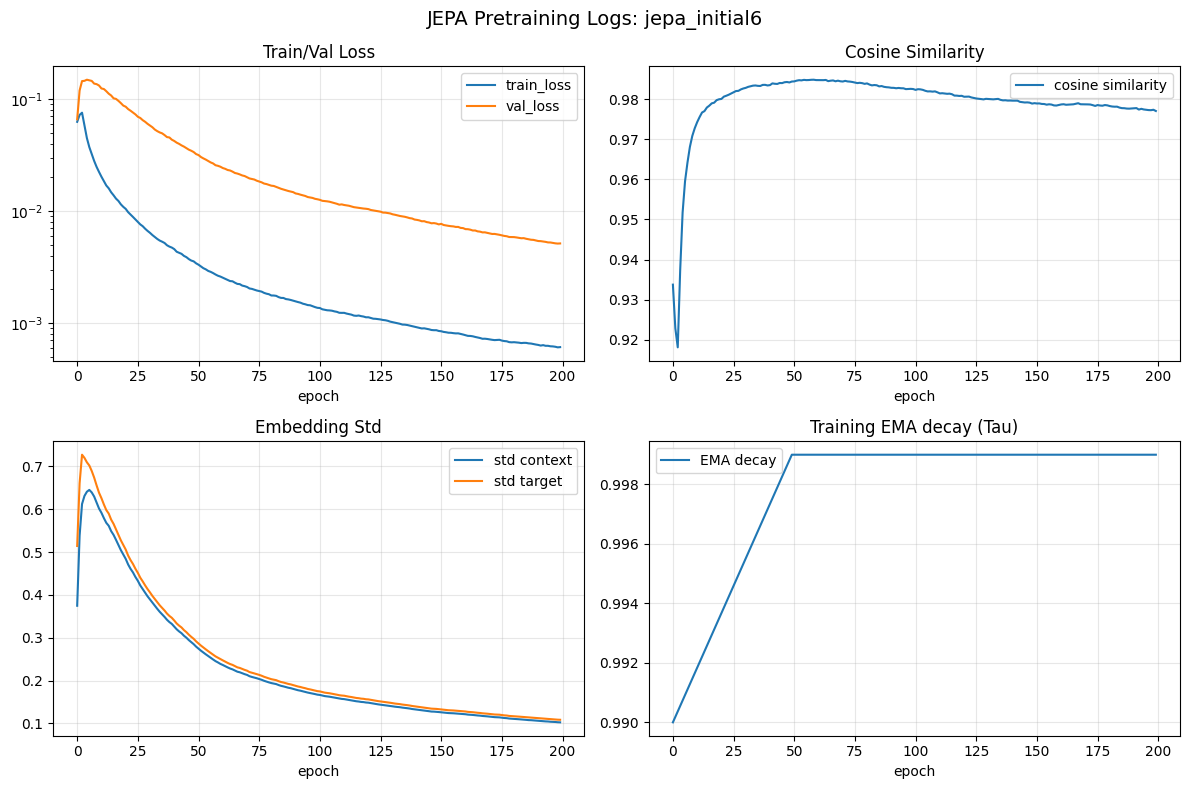

In [59]:
import pandas as pd

# Optional override. If None, use <log_root>/<model_name>_train_log.csv from config.
LOG_CSV_PATH = None

paths_cfg = cfg.get('paths', {})
log_root = paths_cfg.get('log_root', 'logs')
default_log_csv = PROJECT_ROOT / log_root / f"{cfg['model_name']}_train_log.csv"
log_csv_path = Path(LOG_CSV_PATH) if LOG_CSV_PATH else default_log_csv
if not log_csv_path.is_absolute():
    log_csv_path = (PROJECT_ROOT / log_csv_path).resolve()

if not log_csv_path.exists():
    raise FileNotFoundError(f"Pretraining log CSV not found: {log_csv_path}")

log_df = pd.read_csv(log_csv_path)
print(f"Loaded log CSV: {log_csv_path}")
print(f"Rows: {len(log_df)}, Columns: {list(log_df.columns)}")

x_col = 'epoch' if 'epoch' in log_df.columns else log_df.columns[0]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# 1) Core losses
if 'train_loss' in log_df.columns:
    axes[0].plot(log_df[x_col], log_df['train_loss'], label='train_loss')
if 'val_loss' in log_df.columns:
    axes[0].plot(log_df[x_col], log_df['val_loss'], label='val_loss')

# set y axis to log scale
axes[0].set_yscale('log')

axes[0].set_title('Train/Val Loss')
axes[0].set_xlabel(x_col)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 2) Cosine similarity
if 'train_cosine_similarity' in log_df.columns:
    axes[1].plot(log_df[x_col], log_df['train_cosine_similarity'], label='cosine similarity')
axes[1].set_title('Cosine Similarity')
axes[1].set_xlabel(x_col)
axes[1].grid(True, alpha=0.3)
if axes[1].has_data():
    axes[1].legend()

# 3) Embedding std
if 'train_std_ctx' in log_df.columns:
    axes[2].plot(log_df[x_col], log_df['train_std_ctx'], label='std context')
if 'train_std_tgt' in log_df.columns:
    axes[2].plot(log_df[x_col], log_df['train_std_tgt'], label='std target')
axes[2].set_title('Embedding Std')
axes[2].set_xlabel(x_col)
axes[2].grid(True, alpha=0.3)
if axes[2].has_data():
    axes[2].legend()

ema_decay = np.linspace(cfg['jepa_model']['ema_tau_min'], cfg['jepa_model']['ema_tau_max'], num=cfg['training']['warmup_epochs'])
ema_decay = ema_decay.tolist() + [cfg['jepa_model']['ema_tau_max'] for _ in range(len(log_df) - len(ema_decay))]

# 4) Optional extra metrics (auto)

axes[3].plot(log_df[x_col], ema_decay, label='EMA decay')
axes[3].set_title('Training EMA decay (Tau)')
axes[3].set_xlabel(x_col)
axes[3].grid(True, alpha=0.3)
if axes[3].has_data():
    axes[3].legend()

fig.suptitle(f"JEPA Pretraining Logs: {cfg['model_name']}", fontsize=14)
fig.tight_layout()
plt.show()


In [60]:
def _resolve_project_path(path_value: str | None) -> str | None:
    if path_value is None:
        return None
    p = Path(path_value)
    if p.is_absolute():
        return str(p)
    return str((PROJECT_ROOT / p).resolve())


def build_dataset_kwargs(cfg: dict) -> dict:
    d = cfg['dataset']
    return {
        'root_path': _resolve_project_path(d['root_path']),
        'data_path': d['data_path'],
        'start_date': d.get('start_date'),
        'size': [d['context_len'], d['target_len']],
        'use_time_features': d.get('use_time_features', True),
        'rolling_window': d['rolling_window'],
        'train_split': d['train_split'],
        'test_split': d['test_split'],
        'regular_hours_only': d.get('regular_hours_only', True),
        'timeframe': d.get('timeframe', '15min'),
    }


def make_patches(x: torch.Tensor, patch_len: int, stride: int) -> torch.Tensor:
    # Matches Training.callbacks.make_patches
    if x.ndim == 2:
        x = x.unsqueeze(0)
    bsz, seq_len, channels = x.shape
    n = 1 + (seq_len - patch_len) // stride
    patches = x.unfold(dimension=1, size=patch_len, step=stride)
    return patches.contiguous().view(bsz, n, patch_len * channels)


def build_model_and_loader(cfg: dict):
    ds_kwargs = build_dataset_kwargs(cfg)
    print('Using dataset root_path:', ds_kwargs['root_path'])
    dl = DataLoaders(
        datasetCLS=Dataset_Finance_MultiAsset,
        dataset_kwargs=ds_kwargs,
        batch_size_train=cfg['training']['batch_size_train'],
        batch_size_eval=cfg['training']['batch_size_eval'],
        num_workers=4,
        pin_memory=False,
        drop_last_train=False,
        drop_last_eval=False,
        persistent_workers=False,
        prefetch_factor=None,
    )

    model_cfg = cfg['jepa_model']
    num_assets = len(dl.train.dataset.asset_ids)

    context_enc = PatchTSTEncoder(
        patch_len=model_cfg['patch_len'],
        d_model=model_cfg['d_model'],
        n_features=model_cfg['n_features'],
        n_time_features=model_cfg['n_time_features'],
        nhead=model_cfg['nhead'],
        num_layers=model_cfg['num_layers'],
        dim_ff=model_cfg['dim_ff'],
        dropout=model_cfg['dropout'],
        add_cls=model_cfg.get('add_cls', True),
        pooling=model_cfg['pooling'],
        pred_len=model_cfg['pred_len'],
        num_assets=num_assets,
    )

    target_enc = copy.deepcopy(context_enc)

    model = JEPA(
        context_enc=context_enc,
        target_enc=target_enc,
        d_model=model_cfg['d_model'],
        ema_tau_min=model_cfg['ema_tau_min'],
        ema_tau_max=model_cfg['ema_tau_max'],
    )

    ckpt = torch.load(CKPT_PATH, map_location='cpu')
    missing, unexpected = model.load_state_dict(ckpt['model'], strict=False)
    if missing:
        print('Missing keys:', missing)
    if unexpected:
        print('Unexpected keys:', unexpected)

    model = model.to(DEVICE).eval()
    return model, dl


model, dataloaders = build_model_and_loader(cfg)
print('Train samples:', len(dataloaders.train.dataset))
print('Val samples  :', len(dataloaders.valid.dataset))
print('Test samples :', len(dataloaders.test.dataset))


Using dataset root_path: C:\python\koulu\Gradu\Data\polygon
[Dataset_Finance_MultiAsset] Global date splits: train_end=2024-08-01 15:15:00+00:00 val_end=2025-04-29 16:30:00+00:00 n_dates=33179 n_train=23225 n_val=4978 n_test=4976
[Dataset_Finance_MultiAsset] Global date splits: train_end=2024-08-01 15:15:00+00:00 val_end=2025-04-29 16:30:00+00:00 n_dates=33179 n_train=23225 n_val=4978 n_test=4976
[Dataset_Finance_MultiAsset] Global date splits: train_end=2024-08-01 15:15:00+00:00 val_end=2025-04-29 16:30:00+00:00 n_dates=33179 n_train=23225 n_val=4978 n_test=4976
Missing keys: ['context_enc.asset_gate', 'context_enc.asset_emb.weight', 'target_enc.asset_gate', 'target_enc.asset_emb.weight']
Train samples: 744031
Val samples  : 145574
Test samples : 145491


c:\Users\ollik\miniconda3\envs\.graduenv\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\ollik\AppData\Local\Temp\ipykernel_45784\2899960917.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `w

In [ ]:
@torch.no_grad()
def collect_embeddings(loader, model, cfg, max_batches=None):
    m = cfg['jepa_model']
    p_len = m['patch_len']
    p_stride = m['patch_stride']

    all_emb = []
    all_asset = []
    all_ret = []
    all_vol = []

    for i, batch in enumerate(loader):
        if max_batches is not None and i >= max_batches:
            break

        x_ctx = batch['x_context'].to(DEVICE)
        t_ctx = batch['t_context'].to(DEVICE)
        asset_id = batch['asset_id'].to(DEVICE)

        # Match training-time patching callback
        x_ctx_p = make_patches(x_ctx, p_len, p_stride)
        t_ctx_p = make_patches(t_ctx, p_len, p_stride)

        z = model.context_enc(x_ctx_p, t_ctx_p, asset_id=asset_id)

        # Future return over target horizon using raw close prices
        close_path = batch['ohlcv_target'][..., 3].float()  # [B, pred_len]
        ret = (close_path[:, -1] - close_path[:, 0]) / (close_path[:, 0].abs() + 1e-8)
        # Future vol over target horizon using log returns
        vol = close_path.log().diff(dim=1).std(dim=1, keepdim=True)

        all_emb.append(z.detach().cpu().numpy())
        all_asset.append(batch['asset_id'].detach().cpu().numpy())
        all_ret.append(ret.detach().cpu().numpy())
        all_vol.append(vol.detach().cpu().numpy())

    emb = np.concatenate(all_emb, axis=0)
    asset = np.concatenate(all_asset, axis=0)
    fut_ret = np.concatenate(all_ret, axis=0)
    fut_vol = np.concatenate(all_vol, axis=0)
    return emb, asset, fut_ret, fut_vol

# Reduce max_batches if this is slow on your machine
MAX_TRAIN_BATCHES = 300
MAX_TEST_BATCHES = 50

X_train, a_train, y_ret, y_vol = collect_embeddings(dataloaders.train_loader(), model, cfg, max_batches=MAX_TRAIN_BATCHES)
X_test, a_test, y_ret_test, y_vol_test = collect_embeddings(dataloaders.val_loader(), model, cfg, max_batches=MAX_TEST_BATCHES)

print('X_train:', X_train.shape, 'X_test:', X_test.shape)
print('y_train mean/std:', float(y_ret.mean()), float(y_ret.std()))


X_train: (76800, 192) X_test: (12800, 192)
y_train mean/std: 0.0007050490821711719 0.021887486800551414


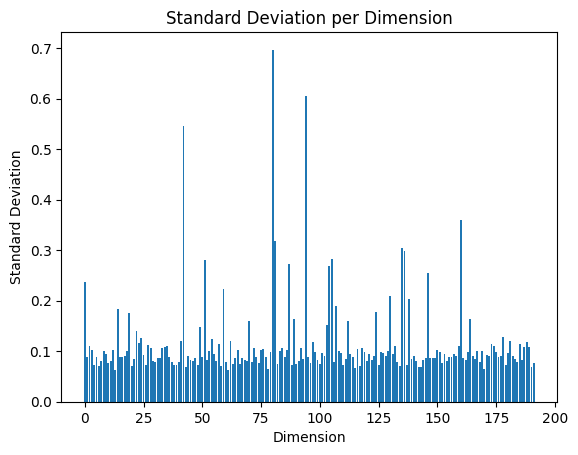

In [ ]:
def embedding_collapse_stats(X):
    # Useful sanity check: low variance/effective rank suggests collapse
    Xc = X - X.mean(axis=0, keepdims=True)
    dim_std = Xc.std(axis=0)
    cov = np.cov(Xc, rowvar=False)
    eigvals = np.linalg.eigvalsh(cov)
    eigvals = np.clip(eigvals, 1e-12, None)
    pr = (eigvals.sum() ** 2) / (np.square(eigvals).sum())  # participation ratio
    return {
        'mean_dim_std': float(dim_std.mean()),
        'min_dim_std': float(dim_std.min()),
        'max_dim_std': float(dim_std.max()),
        'effective_rank_participation_ratio': float(pr),
    }

collapse = embedding_collapse_stats(X_train)
collapse

# calculate the std for each dimension and show in bar graph
def std_per_dim(X):
    Xc = X - X.mean(axis=0, keepdims=True)
    dim_std = Xc.std(axis=0)
    return dim_std

std_per_dim = std_per_dim(X_train)

plt.bar(range(len(std_per_dim)), std_per_dim)
plt.xlabel('Dimension')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation per Embedding Dimension')
plt.show()


In [63]:
# ---------- Usefulness: linear probes ----------
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)
Xte = scaler.transform(X_test)

# 1) Regression probe: can embedding linearly predict future return?
print('1) Regression probe: can embedding linearly predict future return?')
reg = Ridge(alpha=1.0, random_state=SEED)
reg.fit(Xtr, y_ret)
pred_reg = reg.predict(Xte)

reg_r2 = r2_score(y_ret_test, pred_reg)
reg_rmse = math.sqrt(mean_squared_error(y_ret_test, pred_reg))

# 2) Direction probe: 3 classes from train quantiles(down/flat/up)
print('2) Direction probe: 3 classes from train quantiles (down/flat/up)')
q1, q2 = np.quantile(y_ret, [1/3, 2/3])

def to_3class(y, lo, hi):
    out = np.zeros_like(y, dtype=np.int64)
    out[y > hi] = 2
    out[(y >= lo) & (y <= hi)] = 1
    return out

ytr_cls = to_3class(y_ret, q1, q2)
yte_cls = to_3class(y_ret_test, q1, q2)

clf = LogisticRegression(max_iter=1000, random_state=SEED)
clf.fit(Xtr, ytr_cls)
pred_cls = clf.predict(Xte)

bal_acc = balanced_accuracy_score(yte_cls, pred_cls)

# 3) Non-parametric baseline in embedding space
print('3) Non-parametric baseline in embedding space')
knn = KNeighborsRegressor(n_neighbors=30, weights='distance')
knn.fit(Xtr, y_ret)
pred_knn = knn.predict(Xte)
knn_r2 = r2_score(y_ret_test, pred_knn)

print(f'Regression probe R2:   {reg_r2:.4f}')
print(f'Regression probe RMSE: {reg_rmse:.6f}')
print(f'3-class balanced acc:  {bal_acc:.4f}')
print(f'kNN regression R2:     {knn_r2:.4f}')
print()
print('3-class report:')
print(classification_report(yte_cls, pred_cls, digits=4))


1) Regression probe: can embedding linearly predict future return?


KeyboardInterrupt: 

In [64]:
y_vol

array([[0.00223264],
       [0.00167855],
       [0.00161922],
       ...,
       [0.00194079],
       [0.00245936],
       [0.00259116]], shape=(76800, 1), dtype=float32)

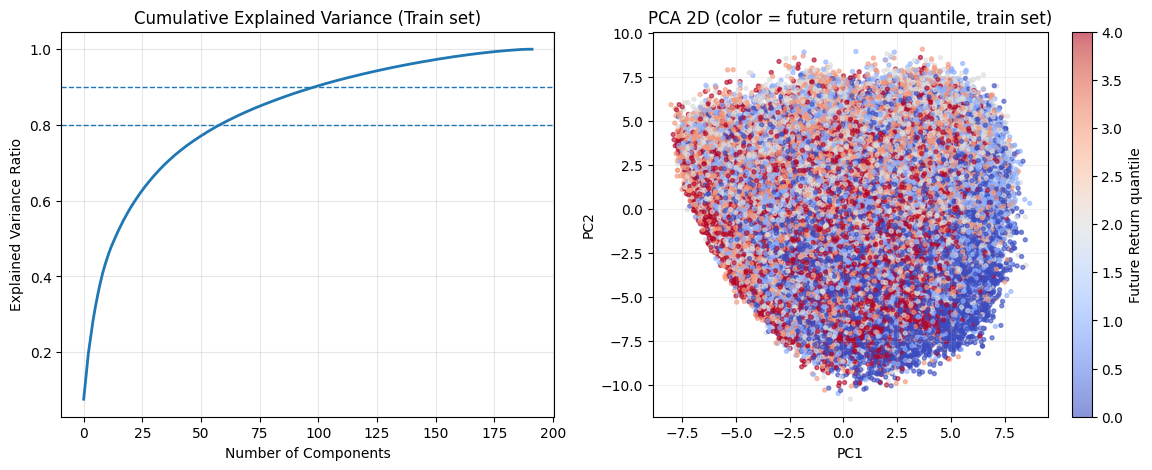

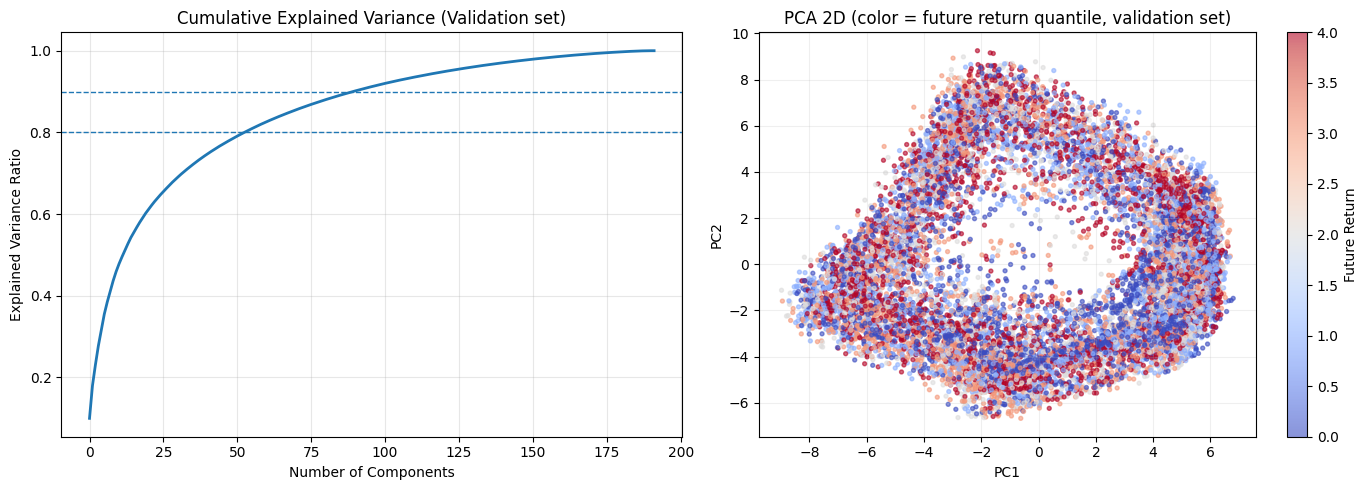

Number of unique assets: 33


In [ ]:
# ---------- Visualization 1: PCA ----------
pca_full = PCA()
pca_full.fit(Xtr)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

pca2 = PCA(n_components=2, random_state=SEED)
Xtr_pca2 = pca2.fit_transform(Xtr)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cum_var, lw=2)
axes[0].axhline(0.8, ls='--', lw=1)
axes[0].axhline(0.9, ls='--', lw=1)
axes[0].set_title('Cumulative Explained Variance (Train set)')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(alpha=0.3)

#divide the future return to 5 bins (so that each bin has same number of points)
y_ret_binned = pd.qcut(y_ret, 5, labels=False)
y_vol_binned = pd.qcut(y_vol.squeeze(), 5, labels=False)

sc = axes[1].scatter(Xtr_pca2[:, 0], Xtr_pca2[:, 1], c=y_ret_binned, s=8, alpha=0.6, cmap='coolwarm')
axes[1].set_title('PCA 2D (color = future return quantile, train set)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.2)
plt.colorbar(sc, ax=axes[1], label='Future Return quantile')

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# sc = axes[0].scatter(Xte_pca2[:, 0], Xte_pca2[:, 1], c=y_vol_binned, s=8, alpha=0.6, cmap='coolwarm')
# axes[0].set_title('PCA 2D (color = future return quantile)')
# axes[0].set_xlabel('PC1')
# axes[0].set_ylabel('PC2')
# axes[0].grid(alpha=0.2)
# plt.colorbar(sc, ax=axes[0], label='Future Return quantile')



# same for validation data
pca_full = PCA()
pca_full.fit(Xte)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

pca2 = PCA(n_components=2, random_state=SEED)
Xte_pca2 = pca2.fit_transform(Xte)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(cum_var, lw=2)
axes[0].axhline(0.8, ls='--', lw=1)
axes[0].axhline(0.9, ls='--', lw=1)
axes[0].set_title('Cumulative Explained Variance (Validation set)')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].grid(alpha=0.3)

#divide the future return to 5 bins (so that each bin has same number of points)
y_ret_test_binned = pd.qcut(y_ret_test, 5, labels=False)

sc = axes[1].scatter(Xte_pca2[:, 0], Xte_pca2[:, 1], c=y_ret_test_binned, s=8, alpha=0.6, cmap='coolwarm')
axes[1].set_title('PCA 2D (color = future return quantile, validation set)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.2)
plt.colorbar(sc, ax=axes[1], label='Future Return')


plt.tight_layout()
plt.show()

# print number of unique assets
asset_ids = np.unique(a_train)
print(f'Number of unique assets: {len(asset_ids)}')


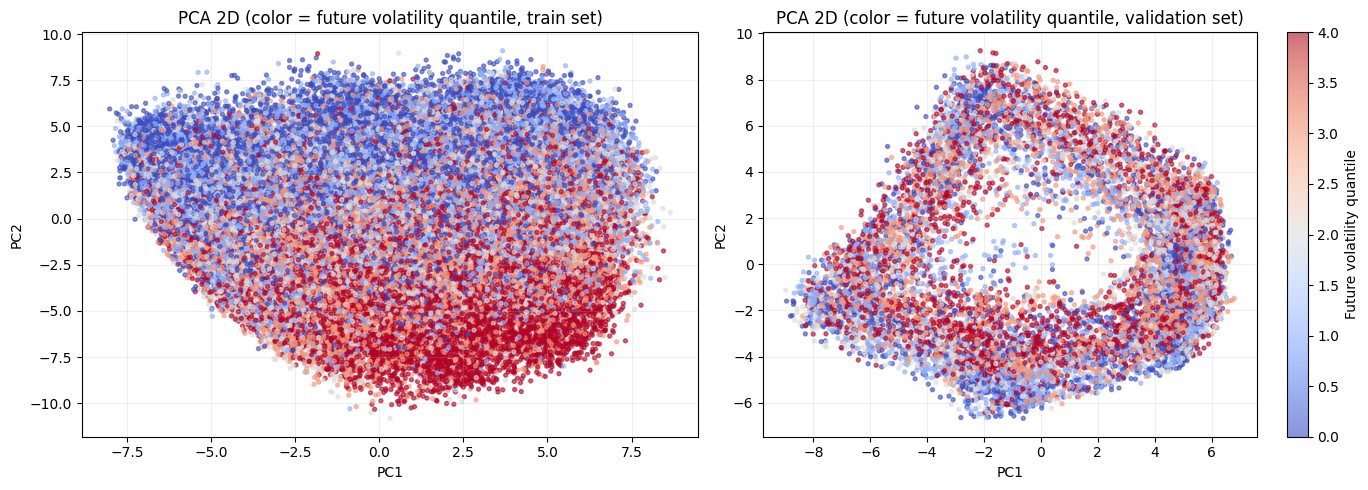

Number of unique assets: 33


In [73]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sc = axes[0].scatter(Xtr_pca2[:, 0], Xtr_pca2[:, 1], c=y_vol_binned, s=8, alpha=0.6, cmap='coolwarm')
axes[0].set_title('PCA 2D (color = future volatility quantile, train set)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(alpha=0.2)

#divide the future return to 5 bins (so that each bin has same number of points)
y_ret_test_binned = pd.qcut(y_ret_test, 5, labels=False)
y_vol_test_binned = pd.qcut(y_vol_test.squeeze(), 5, labels=False)

sc = axes[1].scatter(Xte_pca2[:, 0], Xte_pca2[:, 1], c=y_vol_test_binned, s=8, alpha=0.6, cmap='coolwarm')
axes[1].set_title('PCA 2D (color = future volatility quantile, validation set)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(alpha=0.2)
plt.colorbar(sc, ax=axes[1], label='Future volatility quantile')


plt.tight_layout()
plt.show()

# print number of unique assets
asset_ids = np.unique(a_train)
print(f'Number of unique assets: {len(asset_ids)}')


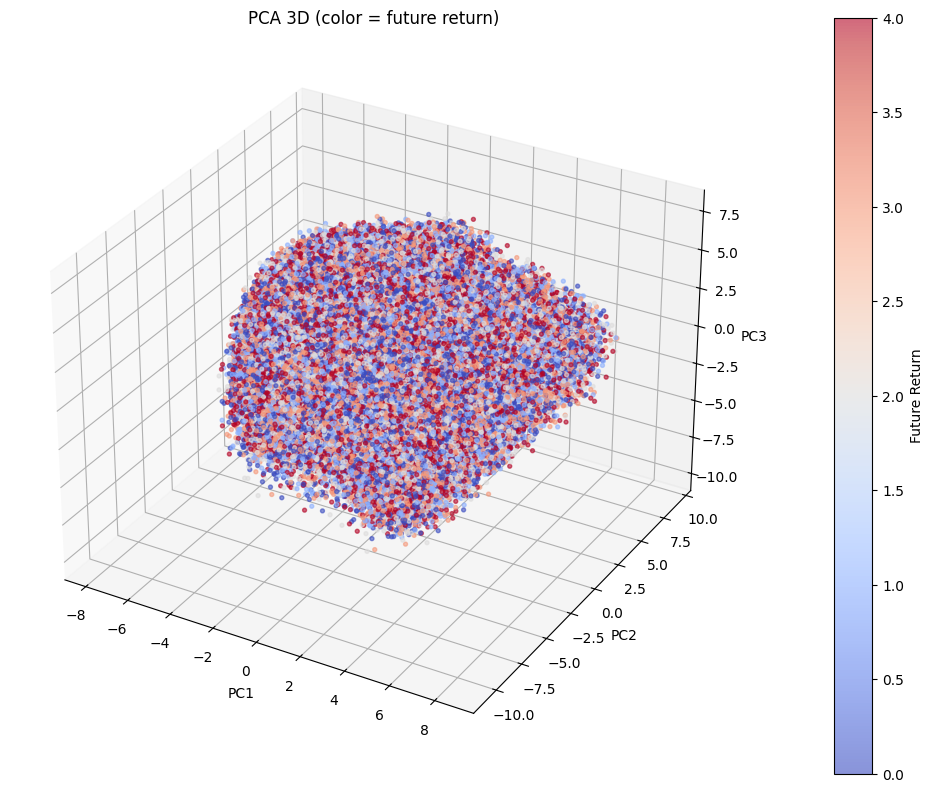

Explained variance ratio (PC1, PC2, PC3): [0.0755 0.0616 0.0595]
Cumulative explained variance (3 PCs): 0.1967


In [58]:
# ---------- Visualization 1b: PCA 3D ----------
pca3 = PCA(n_components=3, random_state=SEED)
Xte_pca3 = pca3.fit_transform(Xtr)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

pts = ax.scatter(
    Xte_pca3[:, 0],
    Xte_pca3[:, 1],
    Xte_pca3[:, 2],
    c=y_ret_binned,
    s=8,
    alpha=0.6,
    cmap='coolwarm'
)

ax.set_title('PCA 3D (color = future return)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
fig.colorbar(pts, ax=ax, pad=0.1, label='Future Return')
plt.tight_layout()
plt.show()

print('Explained variance ratio (PC1, PC2, PC3):', np.round(pca3.explained_variance_ratio_, 4))
print('Cumulative explained variance (3 PCs):', round(float(pca3.explained_variance_ratio_.sum()), 4))


asset indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


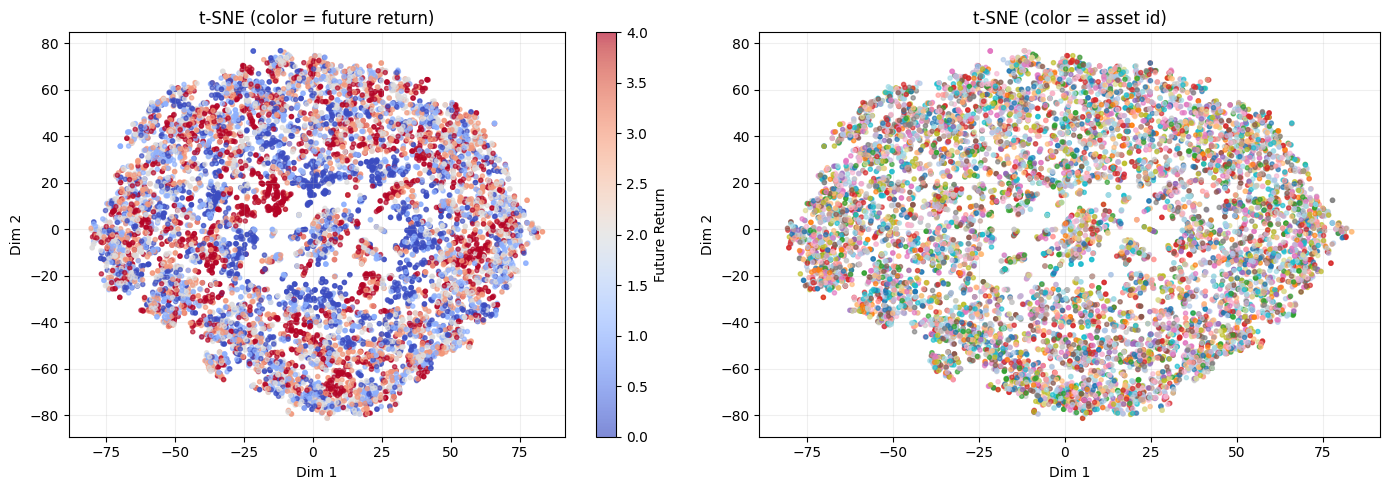

In [36]:
# ---------- Visualization 2: t-SNE ----------
# t-SNE is expensive; sample for speed and readability
MAX_TSNE_POINTS = 10000
n = len(Xte)
idx = np.random.choice(n, size=min(MAX_TSNE_POINTS, n), replace=False)
X_tsne_in = Xtr[idx]
y_tsne = y_ret_binned[idx]
a_tsne = a_train[idx]

print(f"asset indices: {np.unique(a_tsne)}")

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
X_tsne = tsne.fit_transform(X_tsne_in)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sc = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, s=9, alpha=0.65, cmap='coolwarm')
axes[0].set_title('t-SNE (color = future return)')
axes[0].set_xlabel('Dim 1')
axes[0].set_ylabel('Dim 2')
axes[0].grid(alpha=0.2)
# add colorbar
fig.colorbar(sc, ax=axes[0], label='Future Return')

# color by asset id (top frequent assets only)
unique_assets, counts = np.unique(a_tsne, return_counts=True)
top_assets = set(unique_assets[np.argsort(-counts)[:-1]].tolist())
asset_plot = np.array([x if x in top_assets else -1 for x in a_tsne])
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=asset_plot, s=9, alpha=0.65, cmap='tab20')
#axes[1].legend(top_assets, loc='upper right')
axes[1].set_title('t-SNE (color = asset id)')
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')
axes[1].grid(alpha=0.2)



plt.tight_layout()
plt.show()


asset indices: [0 1 2]


C:\Users\ollik\AppData\Local\Temp\ipykernel_45784\2095716374.py:32: UserWarning: Adding colorbar to a different Figure <Figure size 1400x500 with 3 Axes> than <Figure size 1400x500 with 3 Axes> which fig.colorbar is called on.
  plt.colorbar(sc, ax=axes[1], label='Future Return')


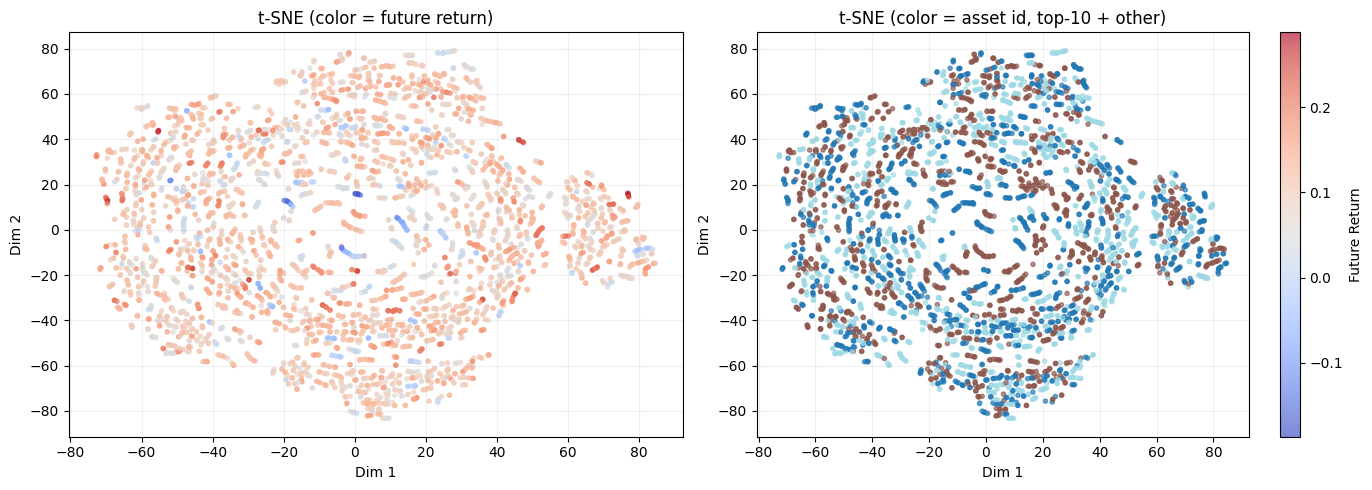

In [12]:
# ---------- Visualization 2: t-SNE ----------
# t-SNE is expensive; sample for speed and readability
MAX_TSNE_POINTS = 4000
n = len(Xte)
idx = np.random.choice(n, size=min(MAX_TSNE_POINTS, n), replace=False)
X_tsne_in = Xte[idx]
y_tsne = y_ret_test[idx]
a_tsne = a_test[idx]

print(f"asset indices: {np.unique(a_tsne)}")

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=SEED)
X_tsne = tsne.fit_transform(X_tsne_in)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_tsne, s=9, alpha=0.65, cmap='coolwarm')
axes[0].set_title('t-SNE (color = future return)')
axes[0].set_xlabel('Dim 1')
axes[0].set_ylabel('Dim 2')
axes[0].grid(alpha=0.2)

# color by asset id (top frequent assets only)
unique_assets, counts = np.unique(a_tsne, return_counts=True)
top_assets = set(unique_assets[np.argsort(-counts)[:10]].tolist())
asset_plot = np.array([x if x in top_assets else -1 for x in a_tsne])
axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=asset_plot, s=9, alpha=0.65, cmap='tab20')
axes[1].set_title('t-SNE (color = asset id, top-10 + other)')
axes[1].set_xlabel('Dim 1')
axes[1].set_ylabel('Dim 2')
axes[1].grid(alpha=0.2)
plt.colorbar(sc, ax=axes[1], label='Future Return')

plt.tight_layout()
plt.show()
